<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TPU/cifar_classifier_tpu_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: 
* https://medium.com/@jannik.zuern/using-a-tpu-in-google-colab-54257328d7da
* https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=pWEYmd_hIWg8

In [0]:
import os
import pickle

# tensorflow imports
import tensorflow as tf
from tensorflow.contrib.training import HParams

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input

# import for showing the confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [0]:
tf.__version__

'1.13.1'

Define hyperparameters for training

In [0]:
hparams = HParams(
    n_classes=10,  # number of different classes in dataset
    learning_rate=1e-3,  # fixed learning rate
    train_batch_size=128*8,  # training batch size
    val_batch_size=128*8,  # validation batch size
    n_epochs=60,  # number of epochs to train
    input_name='input_1',  # name of the input tensor for first layer of Keras model
    data_dir='/tmp/cifar-data/',  # path to data directory
    checkpoint_dir='/tmp/checkpoints/'  # path to model checkpoint directory
)

In [0]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          49G   21G   26G  46% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G  8.0K  6.4G   1% /var/colab
/dev/sda1        55G   22G   34G  40% /etc/hosts
shm             6.0G     0  6.0G   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


## Data download and preprocessing

This code is boilerplate code for downloading and preprocessing of the CIFAR-10 dataset. Credits to [Hvass-Labs](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/cifar10.py).

In [0]:
!pip install albumentations

In [0]:
from albumentations import (
    Compose, HorizontalFlip, Rotate, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma, JpegCompression,
    ToFloat, ShiftScaleRotate
)
import cv2

In [0]:
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
    # CLAHE(p=1.0, clip_limit=2.0),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    # Rotate(limit=15, border_mode=cv2.BORDER_REFLECT_101),
    # JpegCompression(quality_lower=50, quality_upper=100, p=0.5),
    ToFloat(max_value=255)
])

AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

In [0]:
# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = hparams.n_classes

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def download(base_url, filename, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        url = base_url + filename
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=save_path)

        print(" Done!")


def maybe_download_and_extract(url=data_url, download_dir=hparams.data_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.

    If filename=="" then return the directory of the files.
    """

    return os.path.join(hparams.data_dir, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.

    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file,encoding='bytes')

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    # raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


def load_class_names():
    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.

    The data-set is split into 5 data-files which are merged here.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=np.uint8)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls


def load_validation_data():

    images, cls = _load_data(filename="test_batch")

    images = images[5000:, :, :, :]
    cls = cls[5000:]

    return images, cls

def load_testing_data():


    images, cls = _load_data(filename="test_batch")

    images = images[:5000, :, :, :]
    cls = cls[:5000]

    return images, cls

In [0]:
maybe_download_and_extract()
x_val, y_val = load_validation_data()

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch


In [0]:
x_val.shape

(5000, 32, 32, 3)

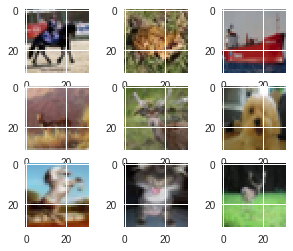

In [0]:
fig = plt.figure(figsize=(5,4))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, i * 3 + j + 1)
        ax.imshow(x_val[i * 3 + j])

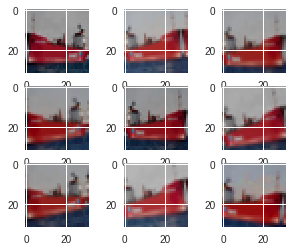

In [0]:
fig = plt.figure(figsize=(5,4))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, i * 3 + j + 1)
        ax.imshow((AUGMENTATIONS_TRAIN(image=x_val[2])["image"] * 255).astype(np.uint8))

# Sequence Class

In [0]:
from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence

In [0]:
class CIFAR10Sequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

In [0]:
x_val, y_val = load_validation_data()
valid_gen = CIFAR10Sequence(x_val, y_val, hparams.val_batch_size, augmentations=AUGMENTATIONS_TEST)

Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch


In [0]:
is_generator_or_sequence(valid_gen )

True

In [0]:
valid_gen[2][0].shape

(1024, 32, 32, 3)

# Network architecture

The below code defines the architecture of the neural network we are going to train. We will be using the infamous Resnet architecture with Shortcut connections and bottlenecs. The paper may be found [here](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf).

We will be using the `tensorflow.keras` API - TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality. Keras is able to use TensorFlow as its backend for tensor processing during training and inference, making Keras easy-to-use but also just as fast as pure TensorFlow models.

The model code is part of the Keras examples and may be found [here](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py).

In [0]:
from tensorflow.keras.regularizers import l2

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Fit the classifier


First, let's make sure we are connected to a TPU runtime. The below lines should output a list of 8 TPU devices connected to our session. If not, we receive an error.

In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.85.110.178:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 10447589990399745755),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1023127219608061129),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4448951322304478444),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5429575976036176408),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7858007824624927224),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 10133592829226009250),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12717714994154225019),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 18040394914887073113),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 10935008666

In [0]:
resnet_model = resnet_v2(
    (32, 32, 3),
    depth=110, num_classes=hparams.n_classes)
resnet_model = tf.contrib.tpu.keras_to_tpu_model(
    resnet_model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
resnet_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

INFO:tensorflow:Querying Tensorflow master (grpc://10.85.110.178:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10447589990399745755)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1023127219608061129)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4448951322304478444)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5429575976036176408)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7858007824624927224)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

In [0]:
# # Validation data
# x_val, y_val = load_validation_data()
# valid_gen = CIFAR10Sequence(x_val, y_val, hparams.val_batch_size, augmentations=AUGMENTATIONS_TEST)

# imgs, ys = [], []
# for i in range(len(valid_gen)):
#     tmp1, tmp2 = valid_gen[i]
#     imgs.append(tmp1), ys.append(tmp2)
# valid_x = np.concatenate(imgs)
# valid_y = np.concatenate(ys)
# valid_x.shape, valid_y.shape, np.max(valid_x), np.min(valid_y), np.max(valid_y)

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

# Download and extract CIFAR-10 data
maybe_download_and_extract()

# training data
x_train, y_train = load_training_data()
train_gen = CIFAR10Sequence(x_train, y_train, hparams.train_batch_size, augmentations=AUGMENTATIONS_TRAIN)

# Validation data
x_val, y_val = load_validation_data()
valid_gen = CIFAR10Sequence(x_val, y_val, hparams.val_batch_size, augmentations=AUGMENTATIONS_TEST)

# Define callbacks
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=hparams.checkpoint_dir)
]

# Warmup for 3 epochs
resnet_model.fit_generator(
    train_gen,
    epochs=1,
    workers=2, use_multiprocessing=False)

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(128, 1), dtype=tf.int32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 140.8527615070343 secs
INFO:tensorflow:Setting weights o

In [0]:
# Training
resnet_model.fit_generator(
    train_gen,
    epochs=hparams.n_epochs-1-20,
    validation_data=valid_gen,
    workers=2, use_multiprocessing=False,
    callbacks=callbacks)

Epoch 1/39
48/49 [============================>.] - ETA: 0s - loss: 2.9587 - sparse_categorical_accuracy: 0.4964INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(128, 1), dtype=tf.int32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 90.14641976356506 secs
4/5 [=======================>......] - ETA: 28s - loss: 3.7934 - sparse_categorical_accuracy: 0.2383 INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(113,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(113, 32, 32, 3), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(113, 1), dtype=tf.int32, name='dense_1_target_10')]
INFO:tensorflow:Over

In [0]:
resnet_model = tf.contrib.tpu.keras_to_tpu_model(
    resnet_model.sync_to_cpu(),
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
resnet_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=3e-5),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:Querying Tensorflow master (grpc://10.85.110.178:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10447589990399745755)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1023127219608061129)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4448951322304478444)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5429575976036176408)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7858007824624927224)
INFO:tens

In [0]:
# Training
resnet_model.fit_generator(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    workers=2, use_multiprocessing=False,
    callbacks=callbacks)

Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='input_2_20'), TensorSpec(shape=(128, 1), dtype=tf.int32, name='dense_1_target_60')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 273.1299786567688 secs
INFO:tensorflow:Setting weights on TPU model.
16/49 [========>.....................] - ETA: 17:50 - loss: 0.6092 - sparse_categorical_accuracy: 0.9311INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(106,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(106, 32, 32, 3), dtype=tf.float32, name='input_2_20'), TensorSpec(shape=(106, 1), dtype=tf.int32, name='dense_1_target_60')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapp

# Visualization of confusion matrix

The below code takes a confusion matrix and produces a nice and shiny visualization

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch
INFO:tensorflow:Copying TPU weights to the CPU
Confusion matrix, without normalization
[[452   4   5   3   2   0   2   1  13   6]
 [  2 486   0   0   0   0   1   0   2  14]
 [ 17   0 448  11  12   7   9   4   2   2]
 [  4   1   9 413  14  34   9  10   1   2]
 [  0   1   7   4 480   7   6   2   0   0]
 [  3   3   8  31   8 423   1   8   0   3]
 [  2   1   7   9   2   1 468   0   0   1]
 [  4   0   4   4   9   3   0 470   0   1]
 [  8   2   2   0   0   0   0   1 486   5]
 [  7  16   0   0   1   0   1   0   4 484]]


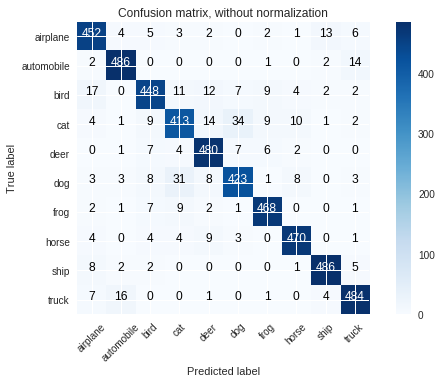

In [0]:
# Testing data
x_test, y_test = load_testing_data()
test_gen = CIFAR10Sequence(x_test, y_test, hparams.val_batch_size, augmentations=AUGMENTATIONS_TEST)

cpu_model = resnet_model.sync_to_cpu()
results = cpu_model.predict_generator(test_gen)

# convert from class probabilities to actual class predictions
predicted_classes = np.argmax(results, axis=1)

# Names of predicted classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Generate the confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [0]:
print("Test Accuracy: %.2f%%" % (sum(y_test == predicted_classes) * 100. / y_test.shape[0]))

Test Accuracy: 92.20%
